**Loading Dataset**

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=3

In [5]:
import zipfile
import os
from pathlib import Path

In [6]:
ZIP_FILE = "/content/drive/MyDrive/datasets/potato_filter.zip"
EXTRACT_PATH = Path("dataset")

In [7]:
if os.path.exists(ZIP_FILE):
    print(f"Found zip file at: {ZIP_FILE}")

    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

    print("Extracted folder contents:")
    print(os.listdir(EXTRACT_PATH))

    class_folders = os.listdir(EXTRACT_PATH)
    print("Class folders:", class_folders)

    import tensorflow as tf

    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        EXTRACT_PATH / "potato_filter",
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

else:
    print(f"Error: Zip file not found at {ZIP_FILE}")
    print("Please check the path. Make sure:")
    print("1. Google Drive is mounted")
    print("2. The file exists in /content/drive/MyDrive/datasets/PlantVillage.zip")
    print("3. The file name is spelled correctly")

Found zip file at: /content/drive/MyDrive/datasets/potato_filter.zip
Extracted folder contents:
['potato_filter']
Class folders: ['potato_filter']
Found 2556 files belonging to 2 classes.


In [8]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['none_potato', 'potato']


In [9]:
class_names = dataset.class_names
class_names

['none_potato', 'potato']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1]


**Visualize Dataset**

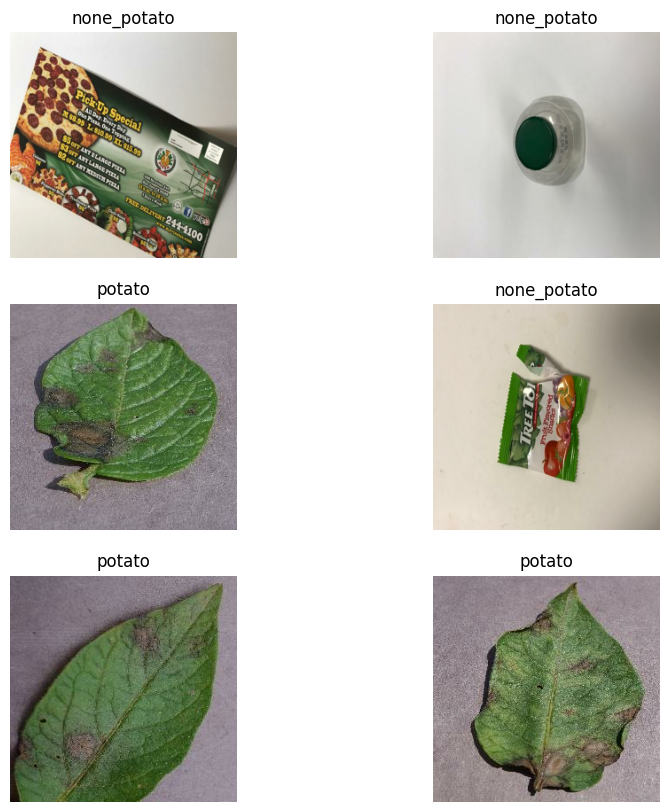

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Dataset Preprocessing**

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Building**

In [18]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='sigmoid'),

])

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

**Model Fitting**

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.6929 - loss: 0.5320 - val_accuracy: 0.9883 - val_loss: 0.0308
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9734 - loss: 0.0816 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.9868 - loss: 0.0372 - val_accuracy: 1.0000 - val_loss: 0.0065


**Model Evaluation**

In [22]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9950 - loss: 0.0184


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

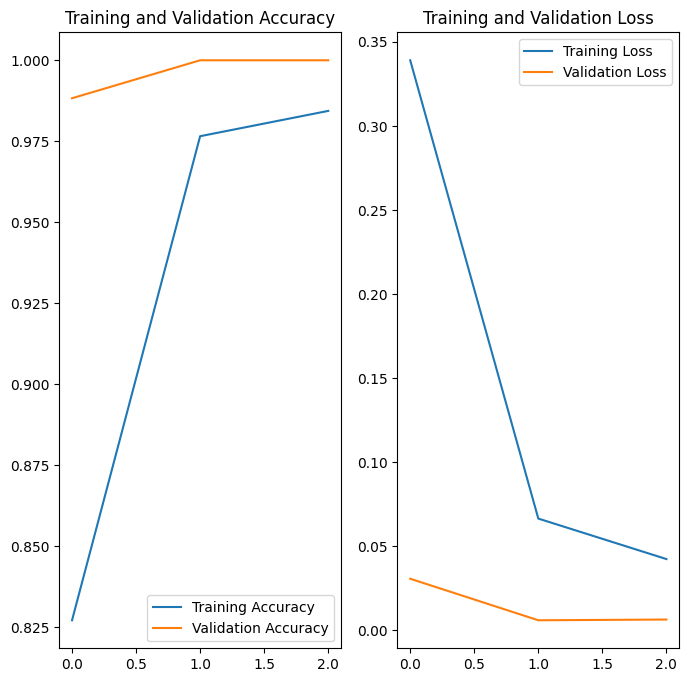

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for imgs, lbls in test_ds:
    lbls_true.extend(tf.reshape(lbls, (-1,)).numpy().tolist())

    probs = model.predict(imgs, verbose=0).ravel()  # (batch_size,)
    lbls_pred.extend((probs >= 0.5).astype(int).tolist())
    pred_confs.extend(probs.tolist())

In [30]:
lbls_true_names = [class_names[i] for i in lbls_true]
lbls_pred_names = [class_names[i] for i in lbls_pred]

In [31]:
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[150   3]
 [  1 102]]


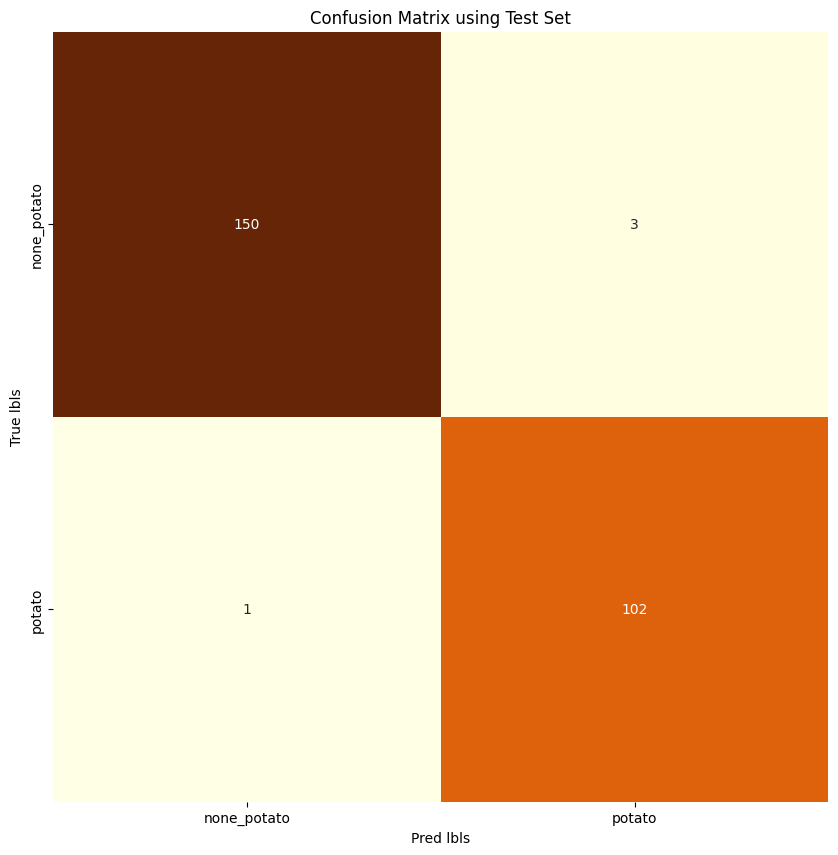

In [32]:
# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [36]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [37]:
# displaying testing set counts
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+-------------+-----+
| none_potato | 153 |
+-------------+-----+
| potato      | 103 |
+-------------+-----+
| Test set    | 256 |
+-------------+-----+


In [38]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s},
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
none_potato,99.34%,98.04%,98.68%
potato,97.14%,99.03%,98.08%


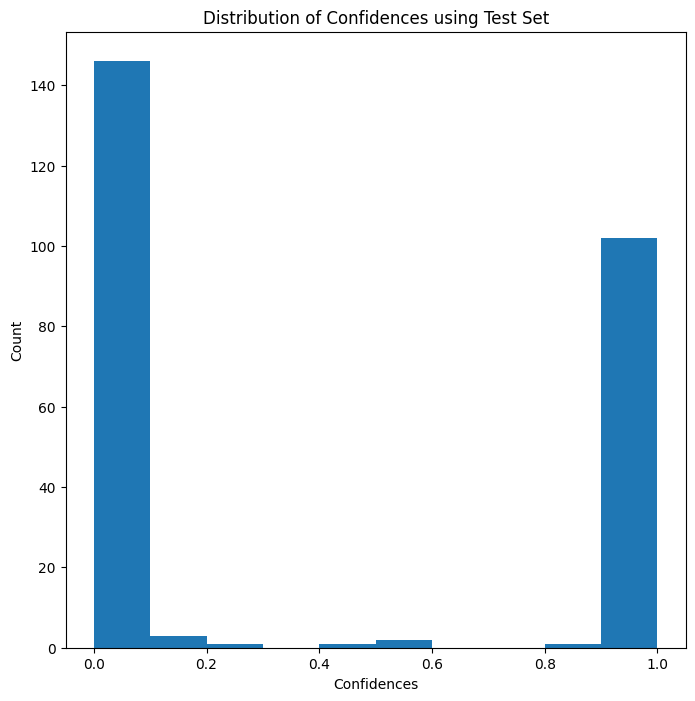

In [39]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

**Prediction**

First image to predict:


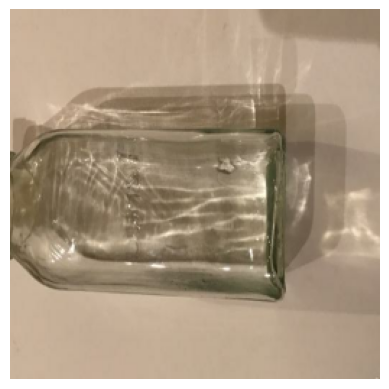

Actual label: none_potato
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted label: none_potato
Confidence: 99.95%


In [33]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis("off")
    plt.show()
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)

    predicted_index = 1 if batch_prediction[0][0] >= 0.5 else 0
    print("Predicted label:", class_names[predicted_index])
    print("Confidence: {:.2f}%".format(batch_prediction[0][0] * 100 if predicted_index == 1 else (1 - batch_prediction[0][0]) * 100))

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_index = 1 if predictions[0][0] >= 0.5 else 0
    predicted_class = class_names[predicted_index]
    confidence = round(100 * predictions[0][0], 2) if predicted_index == 1 else round(100 * (1 - predictions[0][0]), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


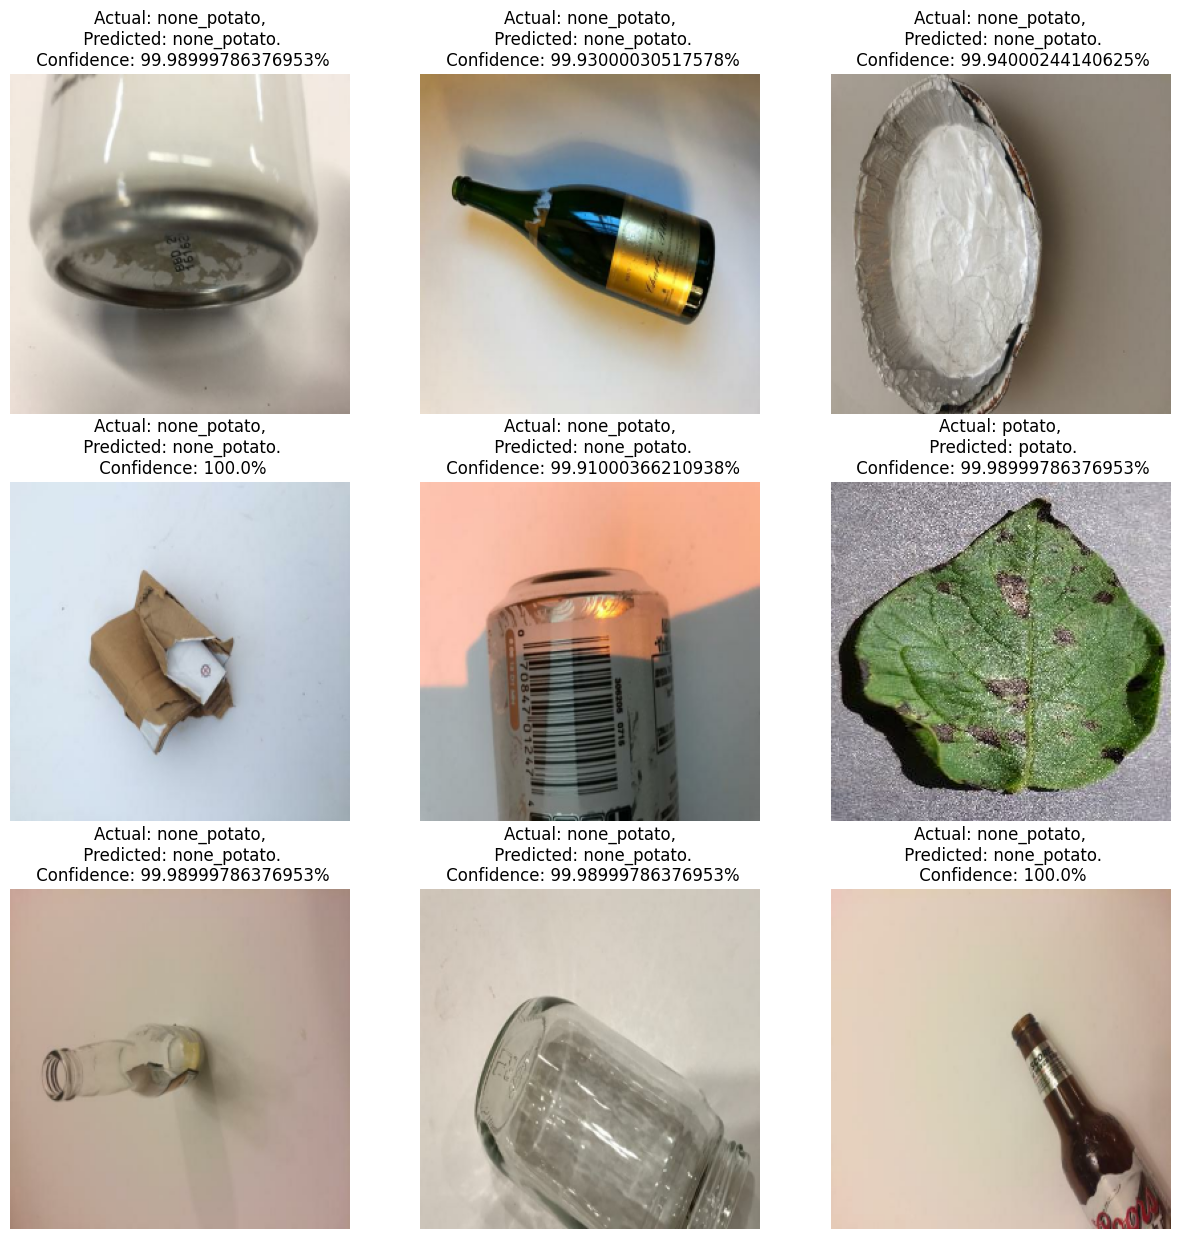

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Model Saving**

In [40]:
# Define target directory
save_dir = "/content/drive/MyDrive/potato-disease-prediction/saved-models"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define full path to save the model
model_path = os.path.join(save_dir, "potato_filter.keras")

# Save the model
model.save(model_path)

print(f"✅ Model saved to: {model_path}")

✅ Model saved to: /content/drive/MyDrive/potato-disease-prediction/saved-models/potato_filter.keras
